In [111]:
#Setup packages etc
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pickle
import bz2
import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from tools.detector import Detector
from tools.readpandas import Get_Momentum

#from trackml.dataset import load_event, load_dataset
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#############################################################
###                                                       ###
###           my functions                                ### 
############################################################
#convert truth direction to local coordinate frame, used to prepare training data
detector = Detector('/Users/pjfox/Dropbox/NN/TrackML/detectors.csv')

def truthmom_to_uvw(a):
    b = detector.GlobalToLocalMom(a[1], a[2], a[3], volid, a[4], a[5])
    norm = np.linalg.norm(b)
    return [b[0], b[1], b[2]]/norm


######################
## given a NN predict the directions
#######################
def my_norm(x):
    return (x/np.linalg.norm(x))

def predicteddirections(NNmodel, data):
    temp = NNmodel.predict(data)
    temp = np.apply_along_axis(my_norm,1,temp)
    return temp

##################
### plot an individual hit (jj = 0,1 for two choices of where to start vector arrows--head or tail)
###################
def plot_a_hit(hit_to_plot, NNmodel,jj):
    lw=1
    hitpattern = hit_to_plot[-8:]
    print(hitpattern)
    truedirection = truthmom_to_uvw(hit_to_plot)
    predicteddirection = predicteddirections(NNmodel, np.reshape(hitpattern,(1,8)))[0]
    print(predicteddirection)
    xs=np.array([hitpattern[0],hitpattern[3]])  #x vals of hit
    ys=np.array([hitpattern[1],hitpattern[4]]) #y vals of hit
    ss = np.array([50*hitpattern[2]/(hitpattern[2] + hitpattern[5]),50*hitpattern[5]/(hitpattern[2] + hitpattern[5])])
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(xs, ys, s=ss)
    line=matplotlib.lines.Line2D([xs[0],xs[0]+truedirection[0]],[ys[0],ys[0]+truedirection[1]])
    ax.add_line(line)
    veclength = 1*np.sqrt((xs.max() - xs.min())**2 + (ys.max() - ys.min())**2)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_zlim([-10,10])
    ax.quiver(xs[jj], ys[jj], 0, truedirection[0], truedirection[1], truedirection[2], length=veclength, normalize=True, color='g',linewidth=lw)
    ax.quiver(xs[jj], ys[jj], 0, predicteddirection[0], predicteddirection[1], predicteddirection[2], length=veclength, normalize=True, color='r',linestyle="--",linewidth=lw)
    ax.scatter(xs, ys, np.zeros(2), s=ss)
    fig.show()
    print("vetors (true, predicted)\n", truedirection,"\n", predicteddirection)
#    print("cosine of angle between = ",csine,"   angle = ", np.arccos(csine)*180/np.pi," degrees")
    return

In [6]:
event = pd.read_pickle("/Users/pjfox/Dropbox/NN/TrackML/from_squirrel/events10.pkl",compression="bz2")

In [7]:
event.columns

Index(['event_id', 'hit_id', 'particle_id', 'x', 'y', 'z', 'tpx', 'tpy', 'tpz',
       'volume_id', 'layer_id', 'module_id', 'ch0_i', 'ch1_i', 'charge_i',
       'ch0_f', 'ch1_f', 'charge_f', 'nch0', 'nch1'],
      dtype='object')

In [101]:
# select some good hits in a particular volume 
volid=8
analysis_choice = 'cluster'#OPTIONS:  'cluster' 'xyz_cluster' 'xyz'

if analysis_choice == 'cluster':
    goodhits=event.loc[event['particle_id'] != 0]
    selectedhits = goodhits.loc[goodhits['volume_id'] == volid]\
    [['hit_id','tpx','tpy','tpz','layer_id','module_id','ch0_i','ch1_i','charge_i','ch0_f','ch1_f','charge_f','nch0','nch1']].values
#^^^^^for cluster analysis

if analysis_choice == 'xyz':
    selectedhits = goodhits.loc[goodhits['volume_id'] == volid]\
    [['hit_id','tpx','tpy','tpz','layer_id','module_id','x','y','z']].values
#^^^^^^for x, y, z analysis

if analysis_choice == 'xyz_cluster':
    selectedhits = goodhits.loc[goodhits['volume_id'] == volid]\
    [['hit_id','tpx','tpy','tpz','layer_id','module_id','ch0_i','ch1_i','charge_i','ch0_f','ch1_f','charge_f', 'nch0', 'nch1','x','y','z']].values
#^^^^^^for x, y, z and cluster analysis
print(selectedhits.shape)

(252694, 14)


In [107]:
#make training data
selectedhits2 = selectedhits#[:100000,]

if analysis_choice == 'cluster':
#for cluster analysis
    y = detector.GlobalToLocalMomBatchNorm(goodhits[goodhits['volume_id'] == volid])
    x = selectedhits2[:,-8:] 

if analysis_choice == 'xyz':
#for x, y, z analysis
    y = detector.GlobalToLocalMomBatchNorm(goodhits[goodhits['volume_id'] == volid])
    x = selectedhits2[:,-3:]  

if analysis_choice == 'xyz_cluster':
#for cluster + x, y, z analysis
    y = detector.GlobalToLocalMomBatchNorm(goodhits[goodhits['volume_id'] == volid])
    x = selectedhits2[:,-11:] 

x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.4, random_state=67)

In [103]:
# 2 NN's one uses cosine_proximity one uses mean square error
NNmodel_CP = Sequential()
NNmodel_CP.add(Dense(units=x_train.shape[1], input_dim=x_train.shape[1]))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=x_train.shape[1]))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(2 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=y_train.shape[1]))       
NNmodel_CP.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])

NNmodel_MSE = Sequential()
NNmodel_MSE.add(Dense(units=x_train.shape[1], input_dim=x_train.shape[1]))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=x_train.shape[1]))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(2 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=y_train.shape[1]))       
NNmodel_MSE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [98]:
#train them!
NNmodel_CP_hist=NNmodel_CP.fit(x_train, y_train, epochs=500, batch_size=117, verbose=1, validation_data=[x_test,y_test])
NNmodel_MSE_hist=NNmodel_MSE.fit(x_train, y_train, epochs=500, batch_size=117, verbose=1, validation_data=[x_test,y_test])

Train on 151616 samples, validate on 101078 samples
Epoch 1/500
151616/151616 [==============================] - 14s 93us/step - loss: -0.5637 - acc: 0.6803 - val_loss: -0.5741 - val_acc: 0.6834
Epoch 2/500
151616/151616 [==============================] - 10s 63us/step - loss: -0.5745 - acc: 0.6851 - val_loss: -0.5754 - val_acc: 0.6834
Epoch 3/500
151616/151616 [==============================] - 10s 63us/step - loss: -0.5778 - acc: 0.6851 - val_loss: -0.5795 - val_acc: 0.6834
Epoch 4/500
151616/151616 [==============================] - 10s 63us/step - loss: -0.5791 - acc: 0.6851 - val_loss: -0.5780 - val_acc: 0.6834
Epoch 5/500
151616/151616 [==============================] - 9s 62us/step - loss: -0.5797 - acc: 0.6851 - val_loss: -0.5806 - val_acc: 0.6834
Epoch 6/500
151616/151616 [==============================] - 10s 67us/step - loss: -0.5801 - acc: 0.6851 - val_loss: -0.5810 - val_acc: 0.6834
Epoch 7/500
151616/151616 [==============================] - 9s 62us/step - loss: -0.5808 -

151616/151616 [==============================] - 9s 61us/step - loss: -0.5851 - acc: 0.6851 - val_loss: -0.5830 - val_acc: 0.6834
Epoch 58/500
151616/151616 [==============================] - 9s 60us/step - loss: -0.5852 - acc: 0.6851 - val_loss: -0.5837 - val_acc: 0.6834
Epoch 59/500
151616/151616 [==============================] - 9s 59us/step - loss: -0.5851 - acc: 0.6851 - val_loss: -0.5830 - val_acc: 0.6834
Epoch 60/500
151616/151616 [==============================] - 9s 61us/step - loss: -0.5850 - acc: 0.6851 - val_loss: -0.5834 - val_acc: 0.6834
Epoch 61/500
151616/151616 [==============================] - 11s 71us/step - loss: -0.5851 - acc: 0.6851 - val_loss: -0.5836 - val_acc: 0.6834
Epoch 62/500
151616/151616 [==============================] - 10s 63us/step - loss: -0.5852 - acc: 0.6851 - val_loss: -0.5819 - val_acc: 0.6834
Epoch 63/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5850 - acc: 0.6851 - val_loss: -0.5831 - val_acc: 0.6834
Epoch 64/5

151616/151616 [==============================] - 10s 63us/step - loss: -0.5865 - acc: 0.6851 - val_loss: -0.5832 - val_acc: 0.6834
Epoch 115/500
151616/151616 [==============================] - 8s 56us/step - loss: -0.5863 - acc: 0.6851 - val_loss: -0.5834 - val_acc: 0.6834
Epoch 116/500
151616/151616 [==============================] - 10s 69us/step - loss: -0.5864 - acc: 0.6851 - val_loss: -0.5826 - val_acc: 0.6834
Epoch 117/500
151616/151616 [==============================] - 8s 56us/step - loss: -0.5864 - acc: 0.6851 - val_loss: -0.5832 - val_acc: 0.6834
Epoch 118/500
151616/151616 [==============================] - 8s 55us/step - loss: -0.5863 - acc: 0.6851 - val_loss: -0.5820 - val_acc: 0.6834
Epoch 119/500
151616/151616 [==============================] - 10s 64us/step - loss: -0.5865 - acc: 0.6851 - val_loss: -0.5830 - val_acc: 0.6834
Epoch 120/500
151616/151616 [==============================] - 9s 59us/step - loss: -0.5865 - acc: 0.6851 - val_loss: -0.5834 - val_acc: 0.6834
Epo

Epoch 171/500
151616/151616 [==============================] - 9s 63us/step - loss: -0.5876 - acc: 0.6851 - val_loss: -0.5825 - val_acc: 0.6834
Epoch 172/500
151616/151616 [==============================] - 9s 60us/step - loss: -0.5876 - acc: 0.6851 - val_loss: -0.5822 - val_acc: 0.6834
Epoch 173/500
151616/151616 [==============================] - 9s 61us/step - loss: -0.5875 - acc: 0.6851 - val_loss: -0.5819 - val_acc: 0.6834
Epoch 174/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5875 - acc: 0.6851 - val_loss: -0.5820 - val_acc: 0.6834
Epoch 175/500
151616/151616 [==============================] - 10s 68us/step - loss: -0.5877 - acc: 0.6851 - val_loss: -0.5822 - val_acc: 0.6834
Epoch 176/500
151616/151616 [==============================] - 9s 59us/step - loss: -0.5878 - acc: 0.6851 - val_loss: -0.5822 - val_acc: 0.6834
Epoch 177/500
151616/151616 [==============================] - 8s 55us/step - loss: -0.5876 - acc: 0.6851 - val_loss: -0.5814 - val_acc

Epoch 228/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5884 - acc: 0.6852 - val_loss: -0.5823 - val_acc: 0.6834
Epoch 229/500
151616/151616 [==============================] - 9s 61us/step - loss: -0.5886 - acc: 0.6852 - val_loss: -0.5816 - val_acc: 0.6834
Epoch 230/500
151616/151616 [==============================] - 10s 65us/step - loss: -0.5885 - acc: 0.6852 - val_loss: -0.5819 - val_acc: 0.6834
Epoch 231/500
151616/151616 [==============================] - 9s 59us/step - loss: -0.5886 - acc: 0.6853 - val_loss: -0.5821 - val_acc: 0.6834
Epoch 232/500
151616/151616 [==============================] - 9s 63us/step - loss: -0.5885 - acc: 0.6852 - val_loss: -0.5819 - val_acc: 0.6834
Epoch 233/500
151616/151616 [==============================] - 11s 72us/step - loss: -0.5888 - acc: 0.6852 - val_loss: -0.5818 - val_acc: 0.6834
Epoch 234/500
151616/151616 [==============================] - 10s 64us/step - loss: -0.5888 - acc: 0.6853 - val_loss: -0.5814 - val_a

Epoch 285/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5893 - acc: 0.6854 - val_loss: -0.5813 - val_acc: 0.6833
Epoch 286/500
151616/151616 [==============================] - 9s 57us/step - loss: -0.5895 - acc: 0.6854 - val_loss: -0.5808 - val_acc: 0.6834
Epoch 287/500
151616/151616 [==============================] - 9s 57us/step - loss: -0.5894 - acc: 0.6854 - val_loss: -0.5805 - val_acc: 0.6833
Epoch 288/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5895 - acc: 0.6854 - val_loss: -0.5807 - val_acc: 0.6833
Epoch 289/500
151616/151616 [==============================] - 9s 56us/step - loss: -0.5896 - acc: 0.6854 - val_loss: -0.5808 - val_acc: 0.6835
Epoch 290/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5897 - acc: 0.6855 - val_loss: -0.5813 - val_acc: 0.6834
Epoch 291/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5895 - acc: 0.6855 - val_loss: -0.5802 - val_acc:

Epoch 342/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5904 - acc: 0.6857 - val_loss: -0.5799 - val_acc: 0.6831
Epoch 343/500
151616/151616 [==============================] - 9s 60us/step - loss: -0.5903 - acc: 0.6855 - val_loss: -0.5801 - val_acc: 0.6833
Epoch 344/500
151616/151616 [==============================] - 10s 69us/step - loss: -0.5905 - acc: 0.6857 - val_loss: -0.5800 - val_acc: 0.6832
Epoch 345/500
151616/151616 [==============================] - 10s 69us/step - loss: -0.5903 - acc: 0.6857 - val_loss: -0.5804 - val_acc: 0.6831
Epoch 346/500
151616/151616 [==============================] - 9s 61us/step - loss: -0.5904 - acc: 0.6855 - val_loss: -0.5794 - val_acc: 0.6830
Epoch 347/500
151616/151616 [==============================] - 10s 65us/step - loss: -0.5901 - acc: 0.6855 - val_loss: -0.5807 - val_acc: 0.6833
Epoch 348/500
151616/151616 [==============================] - 10s 69us/step - loss: -0.5900 - acc: 0.6854 - val_loss: -0.5803 - val_

Epoch 399/500
151616/151616 [==============================] - 9s 59us/step - loss: -0.5908 - acc: 0.6856 - val_loss: -0.5799 - val_acc: 0.6831
Epoch 400/500
151616/151616 [==============================] - 9s 60us/step - loss: -0.5908 - acc: 0.6856 - val_loss: -0.5788 - val_acc: 0.6830
Epoch 401/500
151616/151616 [==============================] - 9s 57us/step - loss: -0.5905 - acc: 0.6857 - val_loss: -0.5795 - val_acc: 0.6832
Epoch 402/500
151616/151616 [==============================] - 9s 59us/step - loss: -0.5911 - acc: 0.6856 - val_loss: -0.5797 - val_acc: 0.6833
Epoch 403/500
151616/151616 [==============================] - 9s 57us/step - loss: -0.5911 - acc: 0.6857 - val_loss: -0.5796 - val_acc: 0.6831
Epoch 404/500
151616/151616 [==============================] - 10s 67us/step - loss: -0.5913 - acc: 0.6858 - val_loss: -0.5799 - val_acc: 0.6831
Epoch 405/500
151616/151616 [==============================] - 10s 64us/step - loss: -0.5907 - acc: 0.6856 - val_loss: -0.5795 - val_ac

Epoch 456/500
151616/151616 [==============================] - 9s 61us/step - loss: -0.5918 - acc: 0.6859 - val_loss: -0.5796 - val_acc: 0.6830
Epoch 457/500
151616/151616 [==============================] - 9s 57us/step - loss: -0.5920 - acc: 0.6859 - val_loss: -0.5787 - val_acc: 0.6829
Epoch 458/500
151616/151616 [==============================] - 9s 57us/step - loss: -0.5915 - acc: 0.6858 - val_loss: -0.5791 - val_acc: 0.6832
Epoch 459/500
151616/151616 [==============================] - 9s 56us/step - loss: -0.5916 - acc: 0.6859 - val_loss: -0.5787 - val_acc: 0.6831
Epoch 460/500
151616/151616 [==============================] - 9s 57us/step - loss: -0.5916 - acc: 0.6859 - val_loss: -0.5789 - val_acc: 0.6831
Epoch 461/500
151616/151616 [==============================] - 9s 58us/step - loss: -0.5919 - acc: 0.6858 - val_loss: -0.5789 - val_acc: 0.6832
Epoch 462/500
151616/151616 [==============================] - 9s 57us/step - loss: -0.5917 - acc: 0.6860 - val_loss: -0.5786 - val_acc:

Epoch 13/500
151616/151616 [==============================] - 8s 53us/step - loss: 0.2241 - acc: 0.6850 - val_loss: 0.2235 - val_acc: 0.6834
Epoch 14/500
151616/151616 [==============================] - 8s 54us/step - loss: 0.2242 - acc: 0.6850 - val_loss: 0.2242 - val_acc: 0.6834
Epoch 15/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2244 - acc: 0.6850 - val_loss: 0.2244 - val_acc: 0.6834
Epoch 16/500
151616/151616 [==============================] - 9s 62us/step - loss: 0.2244 - acc: 0.6850 - val_loss: 0.2242 - val_acc: 0.6834
Epoch 17/500
151616/151616 [==============================] - 9s 58us/step - loss: 0.2243 - acc: 0.6851 - val_loss: 0.2242 - val_acc: 0.6834
Epoch 18/500
151616/151616 [==============================] - 8s 54us/step - loss: 0.2242 - acc: 0.6851 - val_loss: 0.2255 - val_acc: 0.6834
Epoch 19/500
151616/151616 [==============================] - 8s 53us/step - loss: 0.2242 - acc: 0.6850 - val_loss: 0.2235 - val_acc: 0.6834
Epoch 20/500


151616/151616 [==============================] - 8s 51us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 72/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2200 - val_acc: 0.6834
Epoch 73/500
151616/151616 [==============================] - 8s 53us/step - loss: 0.2200 - acc: 0.6851 - val_loss: 0.2201 - val_acc: 0.6834
Epoch 74/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 75/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2201 - val_acc: 0.6834
Epoch 76/500
151616/151616 [==============================] - 8s 51us/step - loss: 0.2200 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 77/500
151616/151616 [==============================] - 8s 53us/step - loss: 0.2200 - acc: 0.6851 - val_loss: 0.2200 - val_acc: 0.6834
Epoch 78/500
151616/151616

Epoch 129/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2198 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 130/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2197 - acc: 0.6851 - val_loss: 0.2200 - val_acc: 0.6834
Epoch 131/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2197 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 132/500
151616/151616 [==============================] - 9s 62us/step - loss: 0.2198 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 133/500
151616/151616 [==============================] - 8s 55us/step - loss: 0.2198 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 134/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 135/500
151616/151616 [==============================] - 8s 53us/step - loss: 0.2197 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 

151616/151616 [==============================] - 8s 52us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 187/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2198 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 188/500
151616/151616 [==============================] - 8s 54us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2203 - val_acc: 0.6834
Epoch 189/500
151616/151616 [==============================] - 8s 53us/step - loss: 0.2201 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 190/500
151616/151616 [==============================] - 8s 54us/step - loss: 0.2197 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 191/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2200 - val_acc: 0.6834
Epoch 192/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2198 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 193/500
151616

151616/151616 [==============================] - 8s 50us/step - loss: 0.2196 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 244/500
151616/151616 [==============================] - 8s 50us/step - loss: 0.2199 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 245/500
151616/151616 [==============================] - 7s 49us/step - loss: 0.2197 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 246/500
151616/151616 [==============================] - 7s 49us/step - loss: 0.2196 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 247/500
151616/151616 [==============================] - 7s 49us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2201 - val_acc: 0.6834
Epoch 248/500
151616/151616 [==============================] - 8s 50us/step - loss: 0.2196 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 249/500
151616/151616 [==============================] - 8s 51us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 250/500
151616

151616/151616 [==============================] - 9s 62us/step - loss: 0.2196 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 301/500
151616/151616 [==============================] - 9s 62us/step - loss: 0.2196 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 302/500
151616/151616 [==============================] - 9s 61us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 303/500
151616/151616 [==============================] - 9s 62us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 304/500
151616/151616 [==============================] - 11s 73us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 305/500
151616/151616 [==============================] - 10s 64us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 306/500
151616/151616 [==============================] - 9s 61us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 307/500
1516

151616/151616 [==============================] - 12s 77us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 358/500
151616/151616 [==============================] - 9s 58us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 359/500
151616/151616 [==============================] - 11s 75us/step - loss: 0.2196 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 360/500
151616/151616 [==============================] - 10s 66us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 361/500
151616/151616 [==============================] - 9s 57us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 362/500
151616/151616 [==============================] - 8s 53us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 363/500
151616/151616 [==============================] - 9s 56us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 364/500
151

151616/151616 [==============================] - 8s 50us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 415/500
151616/151616 [==============================] - 8s 50us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 416/500
151616/151616 [==============================] - 10s 63us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 417/500
151616/151616 [==============================] - 8s 55us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2200 - val_acc: 0.6834
Epoch 418/500
151616/151616 [==============================] - 8s 54us/step - loss: 0.2196 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 419/500
151616/151616 [==============================] - 8s 55us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2201 - val_acc: 0.6834
Epoch 420/500
151616/151616 [==============================] - 8s 53us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 421/500
15161

151616/151616 [==============================] - 10s 65us/step - loss: 0.2193 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 472/500
151616/151616 [==============================] - 9s 62us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2201 - val_acc: 0.6834
Epoch 473/500
151616/151616 [==============================] - 9s 63us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2197 - val_acc: 0.6834
Epoch 474/500
151616/151616 [==============================] - 10s 65us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 475/500
151616/151616 [==============================] - 8s 52us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2200 - val_acc: 0.6834
Epoch 476/500
151616/151616 [==============================] - 9s 58us/step - loss: 0.2195 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 477/500
151616/151616 [==============================] - 9s 60us/step - loss: 0.2194 - acc: 0.6851 - val_loss: 0.2199 - val_acc: 0.6834
Epoch 478/500
1516

Exception ignored in: <function ScopedTFStatus.__del__ at 0x13999dc80>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/c_api_util.py", line 39, in __del__
    c_api.TF_DeleteStatus(self.status)
KeyboardInterrupt


151616/151616 [==============================] - 8s 56us/step - loss: 0.2193 - acc: 0.6851 - val_loss: 0.2198 - val_acc: 0.6834
Epoch 482/500
123903/151616 [=======================>......] - ETA: 1s - loss: 0.2194 - acc: 0.6849

KeyboardInterrupt: 

In [99]:
#save it
NNmodel_CP.save('Direction_predictor_xyz_cluster_CP.h5')
NNmodel_MSE.save('Direction_predictor_xyz_cluster_MSE.h5')

In [104]:
#load it
if analysis_choice == 'cluster':
    NNmodel_CP.load_weights('Direction_predictor_CP.h5')
    NNmodel_MSE.load_weights('Direction_predictor_MSE.h5')
if analysis_choice == 'xyz':
    NNmodel_CP.load_weights('Direction_predictor_xyz_CP.h5')
    NNmodel_MSE.load_weights('Direction_predictor_xyz_MSE.h5')
if analysis_choice == 'xyz_cluster':
    NNmodel_CP.load_weights('Direction_predictor_xyz_cluster_CP.h5')
    NNmodel_MSE.load_weights('Direction_predictor_xyz_cluster_MSE.h5')

In [115]:
NNmodel_MSE.evaluate(x_train, y_train)

151616/151616 [==============================] - 8s 56us/step


[0.395390594918273, 0.5937961692697341]

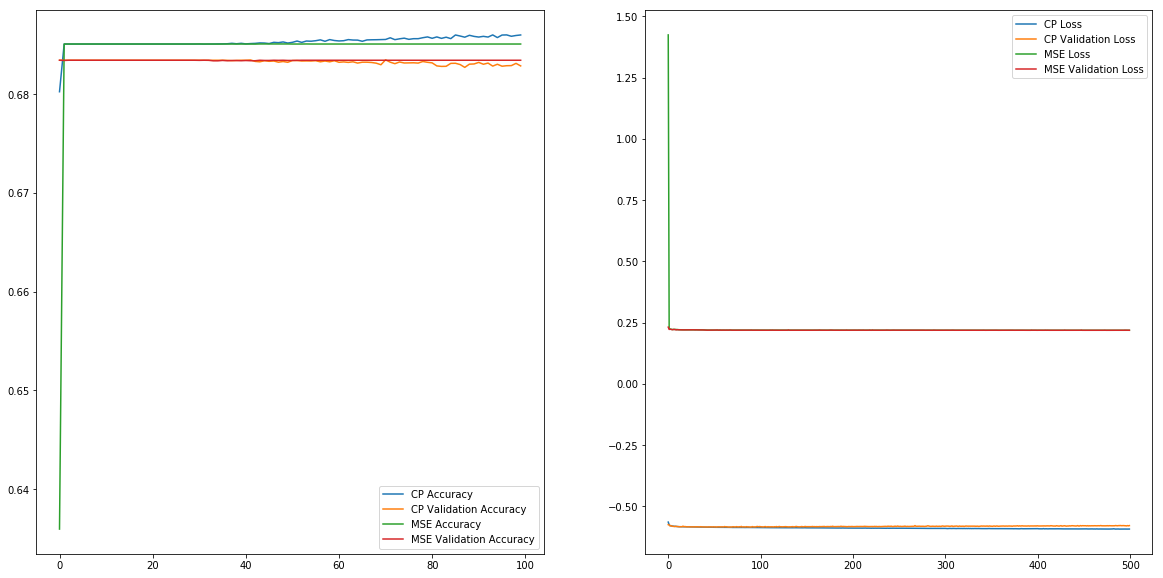

In [116]:
# accuracy etc
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.plot(NNmodel_CP_hist.history['acc'][::5], label = 'CP Accuracy')
ax.plot(NNmodel_CP_hist.history['val_acc'][::5], label = 'CP Validation Accuracy')
ax.plot(NNmodel_MSE_hist.history['acc'][::5], label = 'MSE Accuracy')
ax.plot(NNmodel_MSE_hist.history['val_acc'][::5], label = 'MSE Validation Accuracy')
ax.legend()
ax2.set_yscale('linear')
ax2.set_xscale('linear')
ax2.plot(NNmodel_CP_hist.history['loss'], label = 'CP Loss')
ax2.plot(NNmodel_CP_hist.history['val_loss'], label = 'CP Validation Loss')
ax2.plot(NNmodel_MSE_hist.history['loss'], label = 'MSE Loss')
ax2.plot(NNmodel_MSE_hist.history['val_loss'], label = 'MSE Validation Loss')
ax2.legend()

30314
[216 348 0.0277647003531456 217 356 0.0433662012219429 2 9]
[-0.04433198 -0.848765    0.52690846]
vetors (true, predicted)
 [-0.07139919 -0.83295132  0.54872056] 
 [-0.04433198 -0.848765    0.52690846]


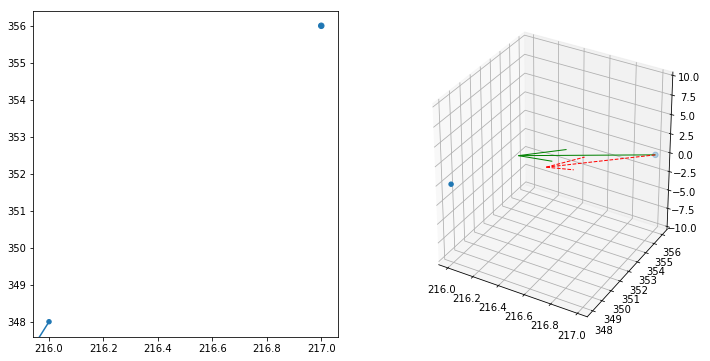

In [114]:
#individual hit, some plots
ii=30124
ii=np.random.randint(0,100000)
print(ii)
hitwewant=selectedhits[ii]
plot_a_hit(hitwewant,NNmodel_CP,1)

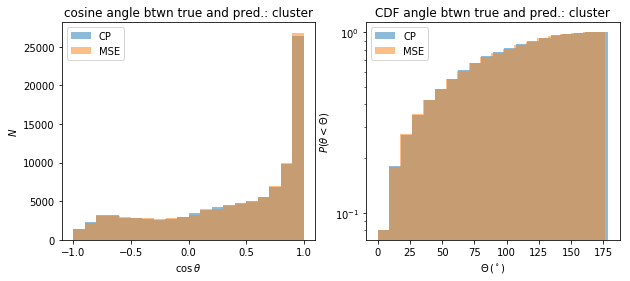

In [108]:
#(cosine of) angle between truth and prediction
predicteddirection_CP = predicteddirections(NNmodel_CP, x_test)
predicteddirection_MSE = predicteddirections(NNmodel_MSE, x_test)
cosines_CP=np.sum(predicteddirection_CP*y_test,axis=1)
cosines_MSE=np.sum(predicteddirection_MSE*y_test,axis=1)
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,4))

ax1.hist(cosines_CP,bins=20,alpha=0.5, label = 'CP')
ax1.hist(cosines_MSE,bins=20,alpha=0.5, label = 'MSE')
ax1.set_title("cosine angle btwn true and pred.: " + analysis_choice)
ax1.set_xlabel(r"$\cos\, \theta$")
ax1.set_ylabel(r"$N$")
ax1.legend()
ax2.hist(np.arccos(cosines_CP)*180./np.pi,bins=20,alpha=0.5,cumulative=True,density=True, label = 'CP')
ax2.hist(np.arccos(cosines_MSE)*180./np.pi,bins=20,alpha=0.5,cumulative=True,density=True, label = 'MSE')
ax2.set_yscale("log")
ax2.set_xlabel(r"$\Theta\, (^\circ)$")
ax2.set_ylabel(r"$P(\theta < \Theta)$")
ax2.set_title("CDF angle btwn true and pred.: " + analysis_choice)
ax2.legend()


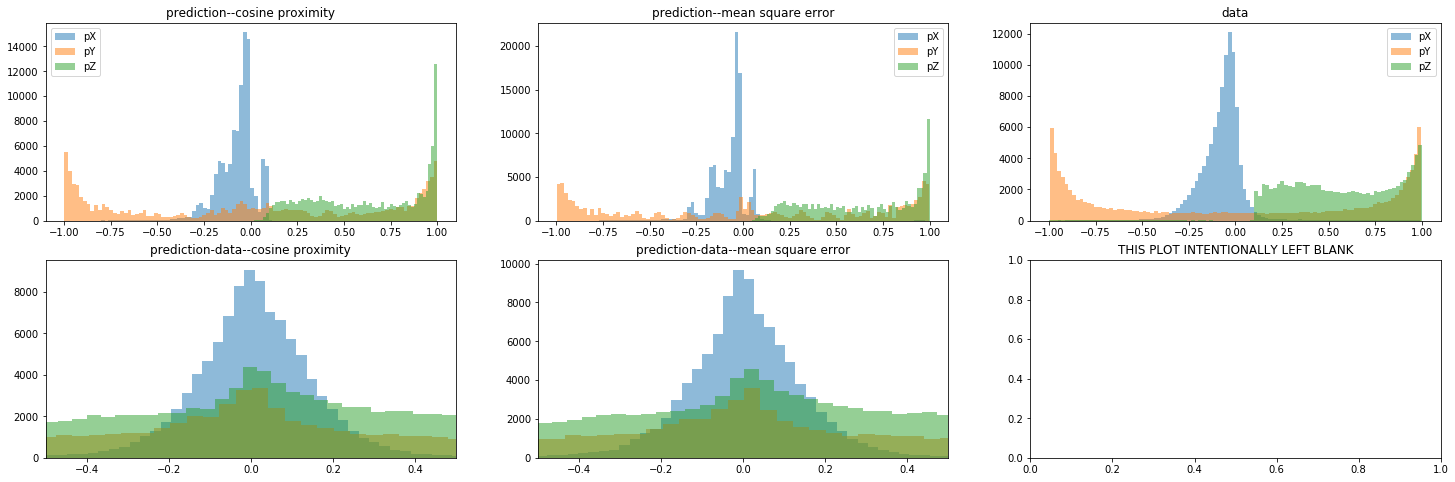

In [106]:
#comparison of data and NN predictions
fig, ax = plt.subplots(2,3,figsize=(25,8))
ax[0,0].hist(predicteddirection_CP[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,0].hist(predicteddirection_CP[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,0].hist(predicteddirection_CP[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,0].set_title("prediction--cosine proximity")
ax[0,0].legend()
ax[0,1].hist(predicteddirection_MSE[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,1].hist(predicteddirection_MSE[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,1].hist(predicteddirection_MSE[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,1].set_title("prediction--mean square error")
ax[0,1].legend()
ax[0,2].hist(y_test[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,2].hist(y_test[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,2].hist(y_test[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,2].set_title("data")
ax[0,2].legend()

ax[1,0].hist(predicteddirection_CP[:,0]-y_test[:,0],bins=100,alpha=0.5)
ax[1,0].hist(predicteddirection_CP[:,1]-y_test[:,1],bins=100,alpha=0.5)
ax[1,0].hist(predicteddirection_CP[:,2]-y_test[:,2],bins=100,alpha=0.5)
ax[1,0].set_xlim(-0.5,0.5)
ax[1,0].set_title("prediction-data--cosine proximity")
ax[1,1].hist(predicteddirection_MSE[:,0]-y_test[:,0],bins=100,alpha=0.5)
ax[1,1].hist(predicteddirection_MSE[:,1]-y_test[:,1],bins=100,alpha=0.5)
ax[1,1].hist(predicteddirection_MSE[:,2]-y_test[:,2],bins=100,alpha=0.5)
ax[1,1].set_xlim(-0.5,0.5)
ax[1,1].set_title("prediction-data--mean square error")

ax[1,2].set_title("THIS PLOT INTENTIONALLY LEFT BLANK")
plt.show()


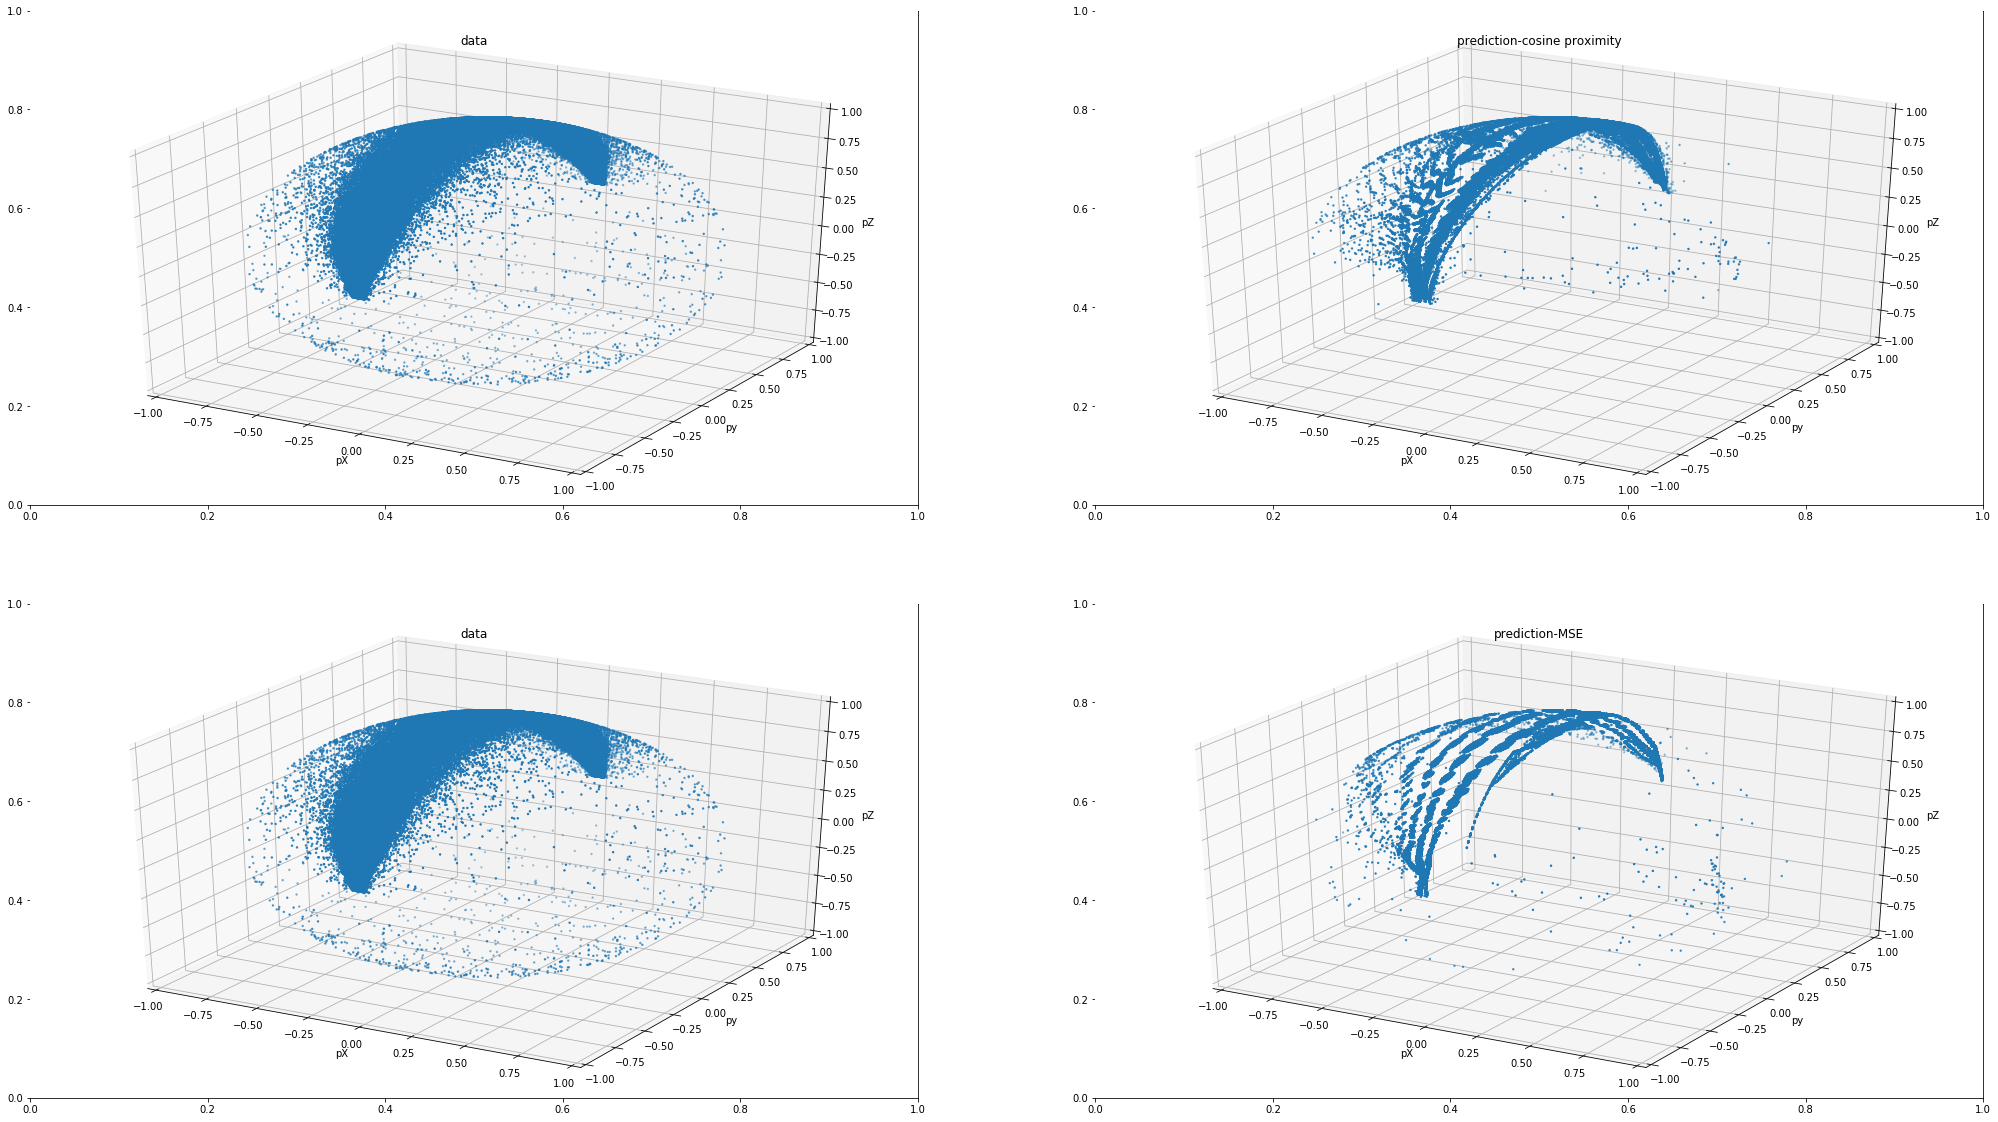

In [109]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig, ax = plt.subplots(2,2,figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    fig.add_subplot(2,2,i,projection='3d')
    ax = fig.gca(projection='3d')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pX")
    ax.set_ylabel("py")
    ax.set_zlabel("pZ")
    ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
   # ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
plt.show()


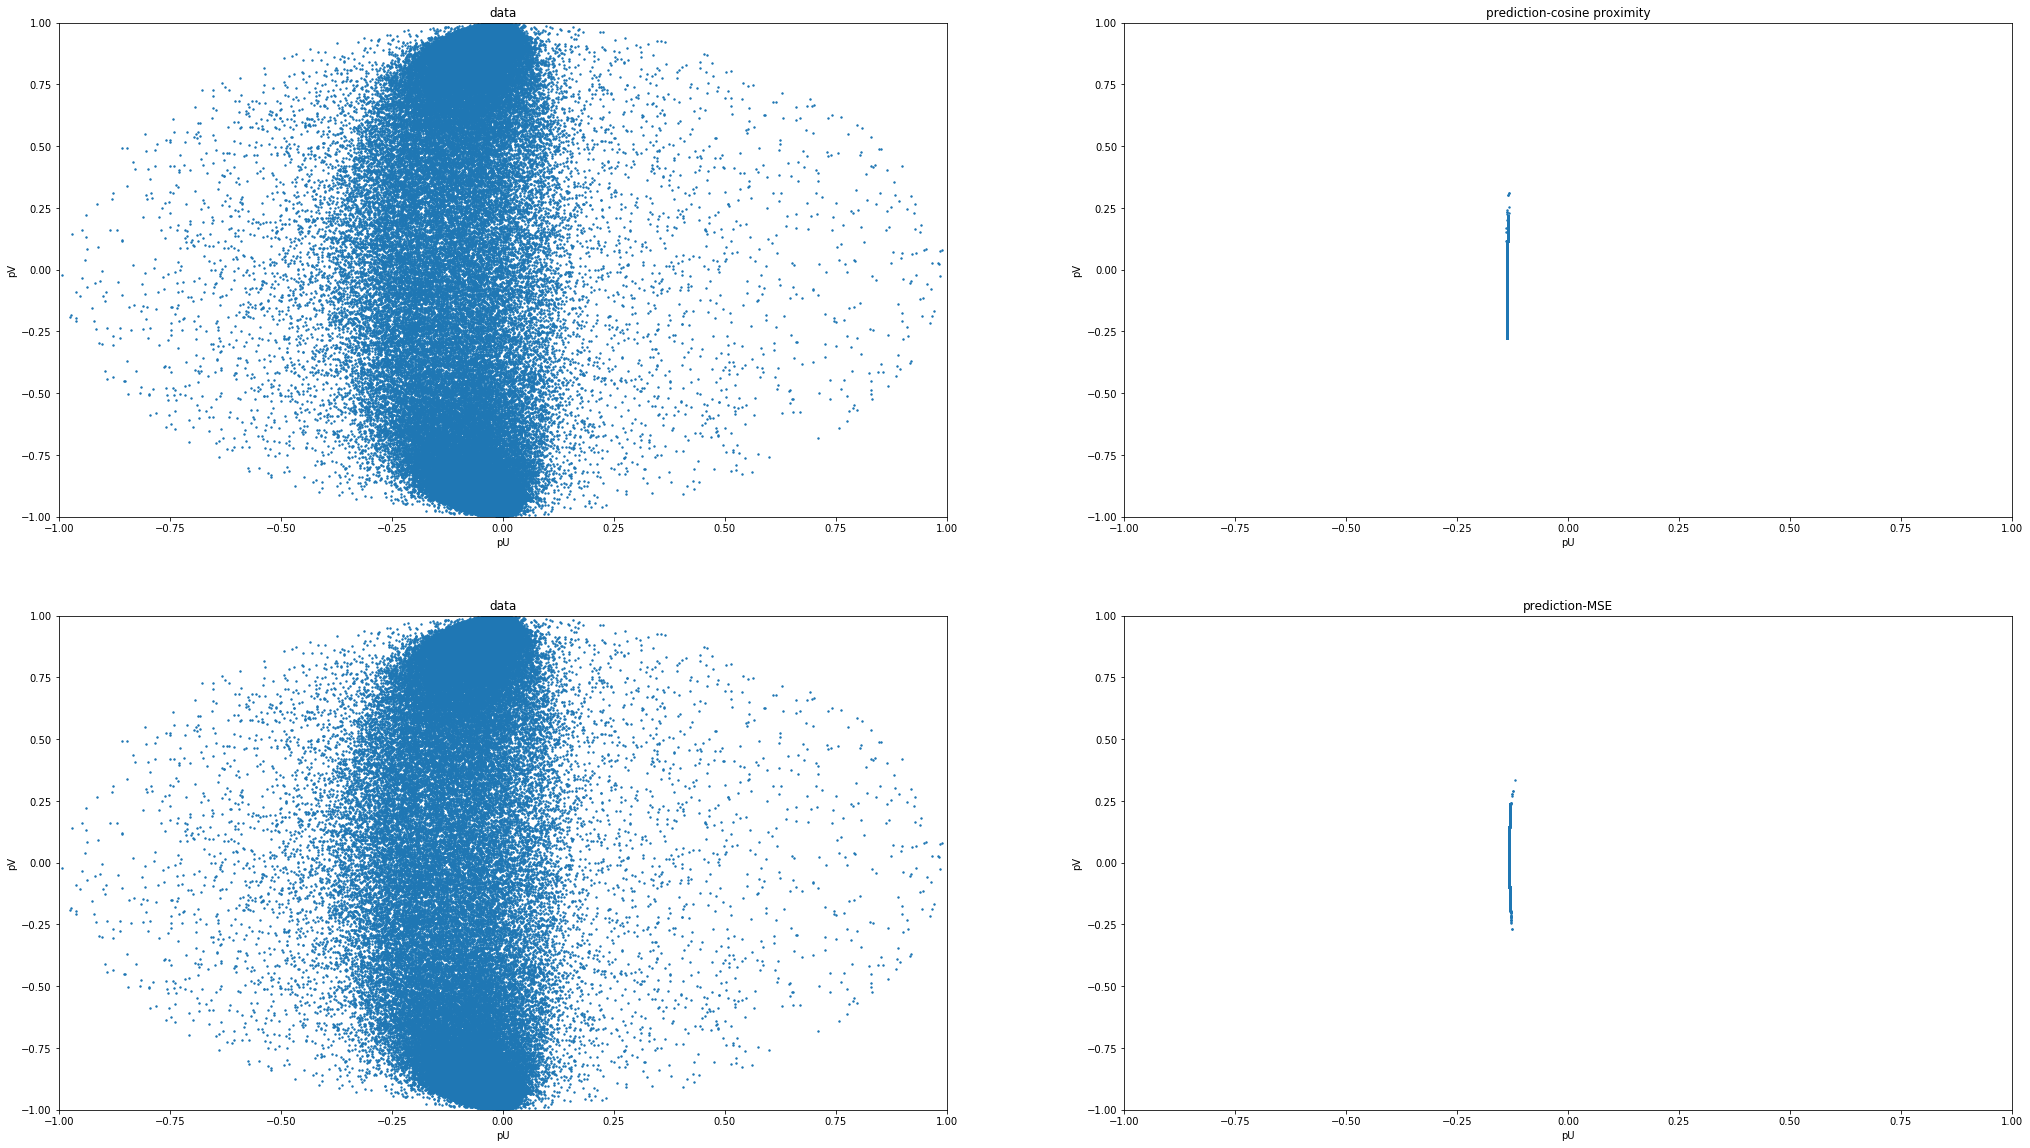

In [64]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig=plt.figure(figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    ax = fig.add_subplot(2,2,i)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pU")
    ax.set_ylabel("pV")
    ax.scatter(data_list[:n_num,0], data_list[:n_num,1],s=2)
   # ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
plt.show()



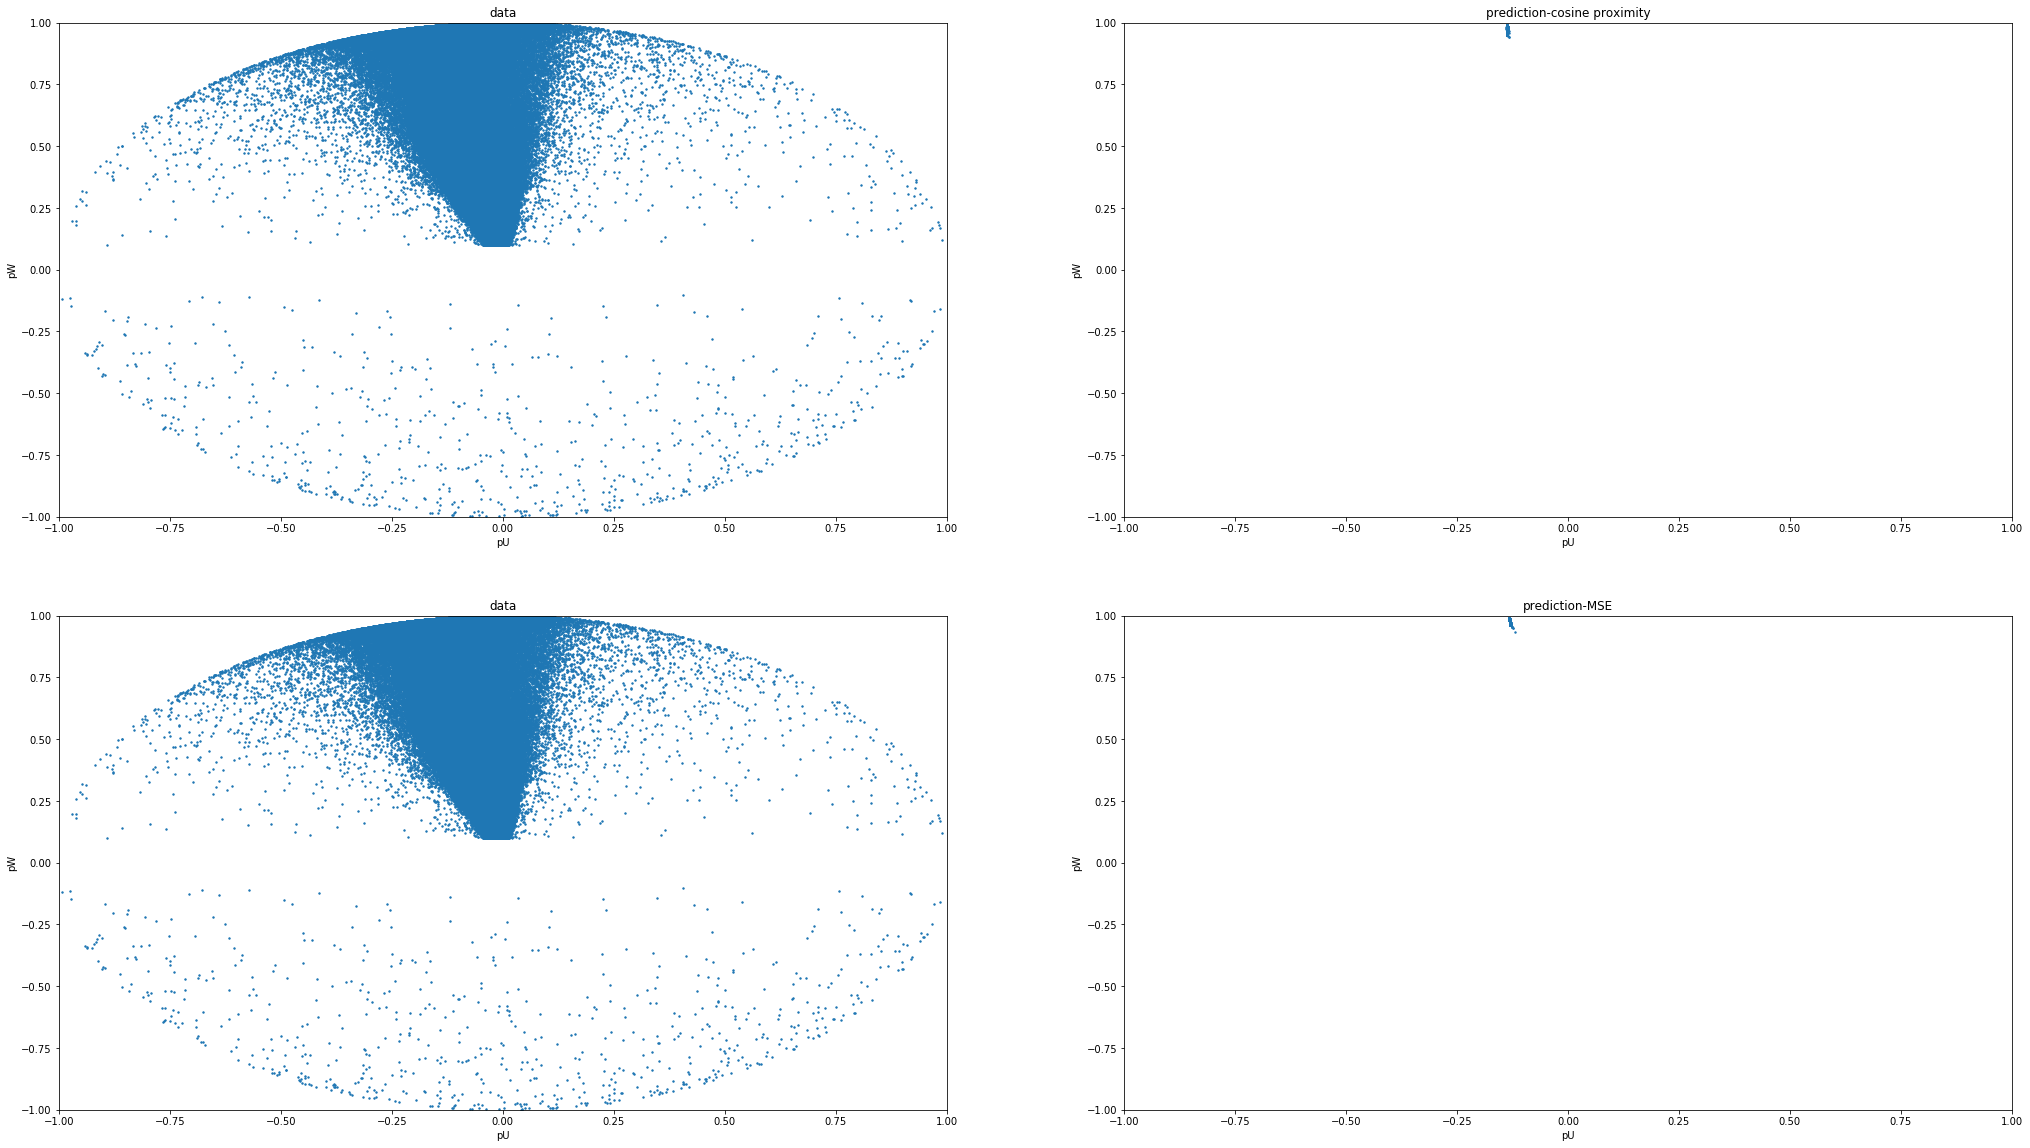

In [65]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig=plt.figure(figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    ax = fig.add_subplot(2,2,i)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pU")
    ax.set_ylabel("pW")
    ax.scatter(data_list[:n_num,0], data_list[:n_num,2],s=2)
plt.show()


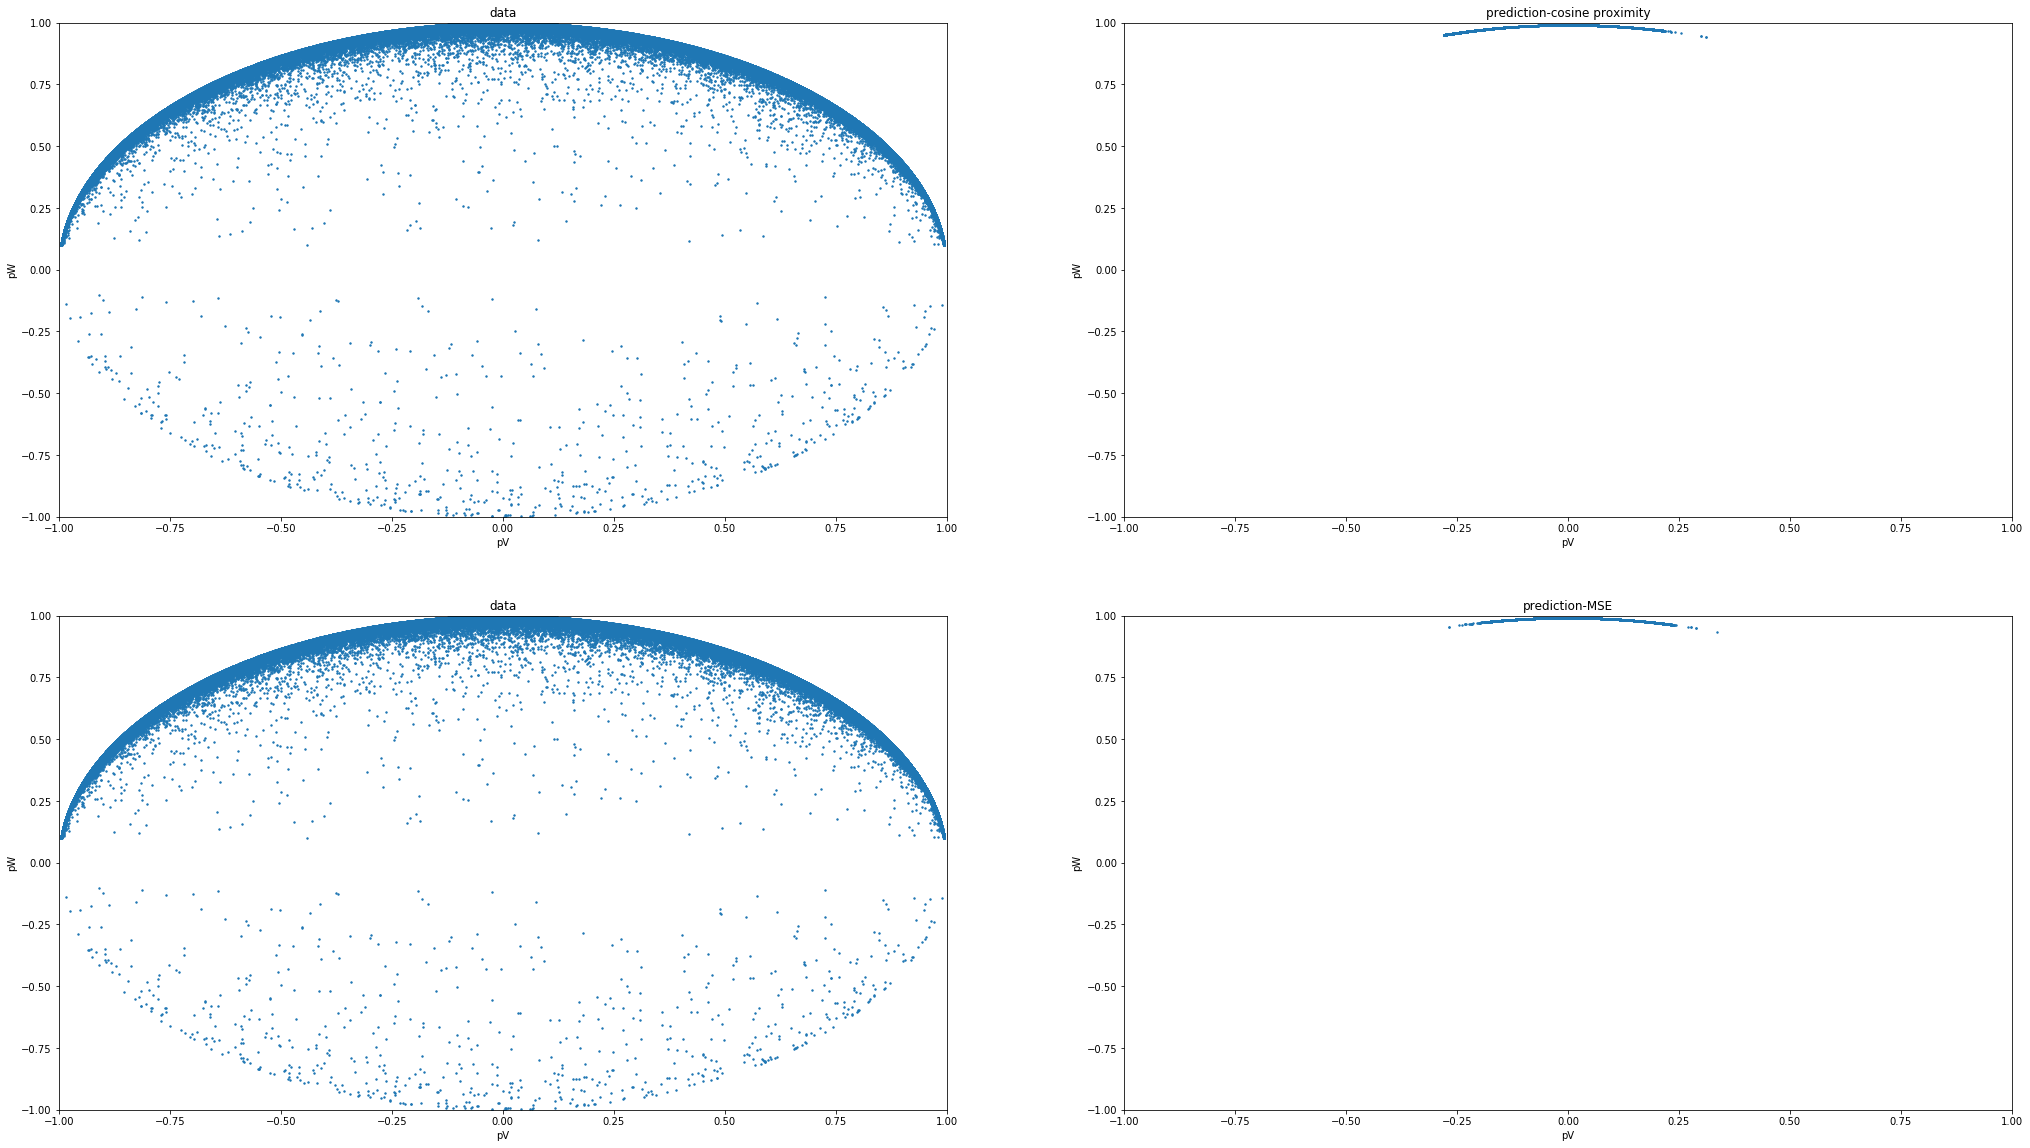

In [66]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig=plt.figure(figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    ax=fig.add_subplot(2,2,i)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pV")
    ax.set_ylabel("pW")
    ax.scatter(data_list[:n_num,1], data_list[:n_num,2],s=2)
   # ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
plt.show()

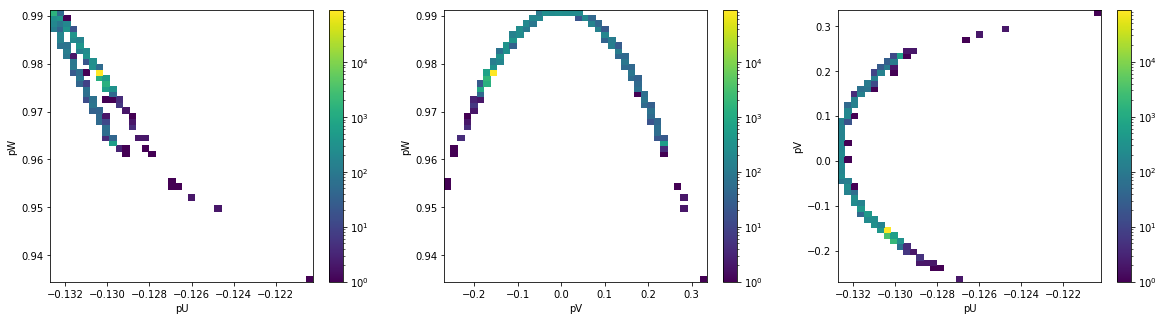

In [67]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,5))
temp=ax1.hist2d(data_list[:n_num,0], data_list[:n_num,2],bins=[40,50],norm=matplotlib.colors.LogNorm())
fig.colorbar(temp[3],ax=ax1)
ax1.set_xlabel("pU")
ax1.set_ylabel("pW")

temp=ax2.hist2d(data_list[:n_num,1], data_list[:n_num,2],bins=[40,50],norm=matplotlib.colors.LogNorm())
fig.colorbar(temp[3],ax=ax2)
ax2.set_xlabel("pV")
ax2.set_ylabel("pW")

temp=ax3.hist2d(data_list[:n_num,0], data_list[:n_num,1],bins=[40,50],norm=matplotlib.colors.LogNorm())
fig.colorbar(temp[3],ax=ax3)
ax3.set_xlabel("pU")
ax3.set_ylabel("pV")
plt.show()

In [204]:
###
##             NOT SO USEFUL !!!
##

#build a function that takes in hit location, vol, layer, mod, hit shape
#and returns the next layers hit location
#does this by apply NN_volid to hit shape, transforming back to global, adding on to location and 
#finding interseciton with next layer

#a helper function to find the next hit, given present hit, direction and radius of present and next layer
def find_next_hit(hitnow, direction, rnow, rnext):
    a = (direction[0]**2 + direction[1]**2) #terms in quadratic equation
    b = 2.0*(hitnow[0]*direction[0] + hitnow[1]*direction[1])
    c = rnow**2 - rnext**2
    [root1, root2] = np.roots([a,b,c])
    if np.imag(root1) > 0:
        print("no solutions for intersection")
        raise NotImplementedError
    if abs(root1) < abs(root2):
        root = root1
    else:
        root = root2
    next_hit = hitnow + root * direction
    return next_hit


#NN_choice = [NN_vol8, NN_vol13, NN_vol17]
def predict_next_hit(hitIN, NN_choice):
    '''hitIN is in form of [tx, ty, tz, volume_id, layer_id, module_id, 8 hit shape parameters]'''
    volid = hitIN[3]
    layer_id = hitIN[4]
    next_layer_id = layer_id + 2
    if next_layer_id > 8:
        print("moved out of module")
        raise NotImplementedError
    module_id = hitIN[5]
    hit_position = hitIN[:3]
    if volid == 8:
        NN_model = NN_choice[0]
    elif volid == 13:
        NN_model = NN_choice[1]
    elif volid == 17:
        NN_model = NN_choice[2]
    else:
        print("Wrong volume ID")
        raise ValueError

    detector._load_element_info(volid,layer_id,module_id)
    pos = detector.cshift
    radius_this_layer = np.sqrt(np.sum((pos*pos)[:2]))    
    detector._load_element_info(volid,next_layer_id,module_id)
    pos = detector.cshift
    radius_next_layer = np.sqrt(np.sum((pos*pos)[:2]))
    hitpattern = hitIN[-8:]
    predicteddirection_local = predicteddirections(NN_model, np.reshape(hitpattern,(1,8)))[0]
    [u ,v, w] = predicteddirection_local
    predicteddirection_global = detector.LocalToGlobalMom(u, v, w, volid,layer_id,module_id)
    #do a rotaion of this direction around y-axis by theta
    theta = math.radians(30.)
    predicteddirection_global_rot = np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta), 0,np.cos(theta)]]).dot(predicteddirection_global)
    #solve to find where hit next layer
    #print(predicteddirection_global,predicteddirection_global_rot)
    central_hit = find_next_hit(hit_position, predicteddirection_global, radius_this_layer, radius_next_layer)
    error_hit = find_next_hit(hit_position, predicteddirection_global_rot, radius_this_layer, radius_next_layer)
    #print(hit_position,central_hit, error_hit)
    #print(radius_this_layer, radius_next_layer)
    error_radius = (error_hit-central_hit)
    error_radius = np.sqrt(np.sum(error_radius*error_radius))
    
    return(np.array(central_hit,dtype=np.float), error_radius)
        

In [312]:
#find all track lables 
all_tracks=np.unique(np.array(goodhits['particle_id']))

###function that checks if cell is inside predicted direction cone
def find_hits_in_cone(hitIN, NN_choice, cone_angle):
    '''hitIN is in form of [tx, ty, tz, volume_id, layer_id, module_id, 8 hit shape parameters]'''
    volid = hitIN[3]
    layer_id = hitIN[4]
    next_layer_id = layer_id + 2
    #print(layer_id,next_layer_id)
    if next_layer_id > 8:
        print("moved out of module")
        raise NotImplementedError
    module_id = hitIN[5]
    hit_position = hitIN[:3]
    if volid == 8:
        NN_model = NN_choice[0]
    elif volid == 13:
        NN_model = NN_choice[1]
    elif volid == 17:
        NN_model = NN_choice[2]
    else:
        print("Wrong volume ID")
        raise ValueError
    hit_location = np.array(hitIN[:3],dtype=np.float)
    print(hit_location)
    hitpattern = hitIN[-8:]
    predicteddirection_local = predicteddirections(NN_model, np.reshape(hitpattern,(1,8)))[0]
    [u ,v, w] = predicteddirection_local
    predicteddirection_global = detector.LocalToGlobalMom(u, v, w, volid,layer_id,module_id)
    possiblehits = np.array(goodhits.loc[(goodhits['volume_id'] == volid) & (goodhits['layer_id'] == next_layer_id)][['x', 'y', 'z']],dtype=np.float)
    print (predicteddirection_global)
    #print(np.linalg.norm(possiblehits-hit_location[np.newaxis,:],axis=1))
    incone = np.dot(possiblehits-hit_location,predicteddirection_global)/np.linalg.norm(possiblehits-hit_location[np.newaxis,:],axis=1) > np.cos(math.radians(cone_angle))
    return possiblehits[incone]

In [334]:
ii=5300
temp=crap[crap[:,2].argsort()][ii]
print(temp)
diff=temp-np.array([ 27.09939957,17.59869957,-52.77109909])
print(diff)
crap2=np.dot(temp-np.array([ 27.09939957,17.59869957,-52.77109909]),np.array([ 0.39324587,0.30762035,-0.86644524]))
crap2/np.linalg.norm(temp-np.array([ 27.09939957,17.59869957,-52.77109909]))

[ 47.82989883  54.05469894 -80.90450287]
[ 20.73049926  36.45599937 -28.13340378]


0.8661895194395233

In [332]:
crap=find_hits_in_cone(testhits[0],[NNmodel_CP,NNmodel_CP,NNmodel_CP],30.)
crap[crap[:,2].argsort()]

[ 27.09939957  17.59869957 -52.77109909]
[ 0.39324587  0.30762035 -0.86644524]


array([[  14.75860023,   70.10690308, -490.82000732],
       [  39.18420029,   61.84270096, -490.48498535],
       [  69.62850189,  -17.83040047, -490.47399902],
       ...,
       [  57.93270111,   43.24689865,  -76.46849823],
       [  57.20009995,   43.92060089,  -76.40110016],
       [  60.2201004 ,   38.00880051,  -76.04920197]])

22523908011851776
5
[0.3932458812078261 0.30762035743538674 -0.8664452623244038]
[ 27.09939957  17.59869957 -52.77109909]
[ 0.39324587  0.30762035 -0.86644524]
688


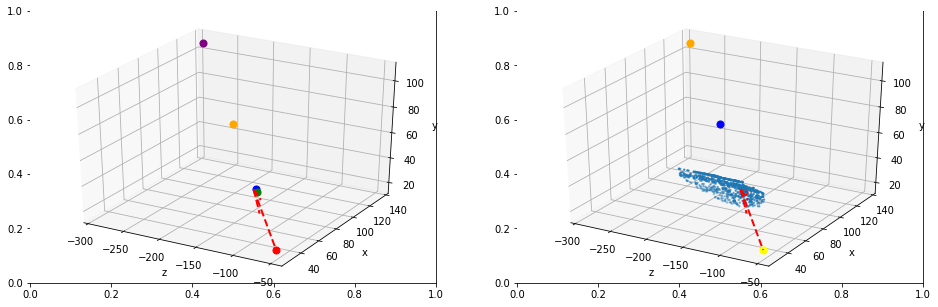

In [337]:
#pick an example track
ii=1456
track_id = all_tracks[ii]
print(track_id)
track = event.loc[(event['particle_id'] == track_id) & (event['event_id']=='1000')]
testhits = np.array(track.loc[track['volume_id'] == volid][['x', 'y', 'z', 'volume_id', 'layer_id', 'module_id', 'ch0_i', 'ch1_i', 'charge_i','ch0_f', 'ch1_f', 'charge_f', 'nch0', 'nch1']])
testhits = testhits[testhits[:,4].argsort()]
print(len(testhits))
nexthit, radius =predict_next_hit(testhits[0],[NNmodel_CP,NNmodel_CP,NNmodel_CP])
directionTEMP=nexthit-testhits[0,:3]
lengthTEMP=np.linalg.norm(directionTEMP)
print(directionTEMP/lengthTEMP)
allincone=find_hits_in_cone(testhits[0],[NNmodel_CP,NNmodel_CP,NNmodel_CP],15.)
print (len(allincone))

###plotting stuff
colors=itertools.cycle(["red", "green", "blue", "orange", "purple", "yellow"])
fig, ax = plt.subplots(1,2,figsize=(16,5))
fig.add_subplot(1,2,1,projection='3d')
ax = fig.gca(projection='3d')
ax.set_xlabel("z")
ax.set_ylabel("x")
ax.set_zlabel("y")
for i in range(len(testhits)):
    ax.scatter(testhits[i,2], testhits[i,0], testhits[i,1],s=50,color=next(colors))
#ax.scatter(possiblehits[:,0],possiblehits[:,1],possiblehits[:,2],s=1)
ax.quiver(testhits[0,2], testhits[0,0], testhits[0,1], directionTEMP[2], directionTEMP[0], directionTEMP[1], length=lengthTEMP, normalize=True, color='r',linestyle="--",linewidth=2)
fig.add_subplot(1,2,2,projection='3d')
ax = fig.gca(projection='3d')
ax.set_xlabel("z")
ax.set_ylabel("x")
ax.set_zlabel("y")
for i in range(len(testhits)):
    ax.scatter(testhits[i,2], testhits[i,0], testhits[i,1],s=50,color=next(colors))
#ax.scatter(possiblehits[:,0],possiblehits[:,1],possiblehits[:,2],s=1)
ax.quiver(testhits[0,2], testhits[0,0], testhits[0,1], directionTEMP[2], directionTEMP[0], directionTEMP[1], length=lengthTEMP, normalize=True, color='r',linestyle="--",linewidth=2)
ax.scatter(allincone[:,2], allincone[:,0], allincone[:,1],s=2)

plt.show()

In [208]:
nexthit, radius =predict_next_hit(testhits[0],[NNmodel_CP,NNmodel_CP,NNmodel_CP])
possiblehits = np.array(goodhits.loc[(goodhits['volume_id'] == testhits[0][3]) & (goodhits['layer_id'] == testhits[0][4]+2)][['x', 'y', 'z']],dtype=np.float)
incone = np.linalg.norm(possiblehits-nexthit[np.newaxis,:],axis=1) < radius
print(len(possiblehits[incone]))

53758


In [282]:
testhits

array([[-28.03809928894043, 14.238300323486328, 59.59519958496094, 8, 2,
        127, 242, 1082, 0.01933559961616993, 243, 1072,
        0.051440101116895676, 2, 11],
       [-63.948001861572266, 33.43230056762695, 136.875, 8, 4, 286, 180,
        1211, 0.05093950033187866, 181, 1201, 0.017291299998760223, 2,
        11],
       [-101.80599975585938, 54.70589828491211, 219.27000427246094, 8, 6,
        568, 286, 177, 0.03589069843292236, 285, 187,
        0.03888370096683502, 2, 11],
       [-149.67100524902344, 83.56690216064453, 325.1579895019531, 8, 8,
        930, 218, 815, 0.03956729918718338, 216, 825,
        0.04891959950327873, 3, 11]], dtype=object)

In [21]:
print(testhits[0], testhits[2])

[-21.54669952392578 -23.07200050354004 2.682569980621338 8 2 114 313 65
 0.24052700400352478 312 64 0.009414929896593094 2 2] [-50.774600982666016 -52.840301513671875 -2.403130054473877 8 4 197 53
 1219 0.013074199669063091 50 1219 0.016213400289416313 4 1]


In [27]:
testhits[:,0]

array([-27.87700080871582, -18.199600219726562, 30.455699920654297,
       70.31849670410156, -28.310300827026367, -63.08300018310547,
       -24.98430061340332, -54.1952018737793, -85.97350311279297,
       -87.4490966796875, -127.02799987792969, 4.880519866943359,
       11.13379955291748, 19.137300491333008, 29.958099365234375,
       19.484399795532227, 44.553199768066406, 72.885498046875],
      dtype=object)

In [105]:
#learn something about detector lay out
layer_layout2=np.around(np.array(event.loc[(event['volume_id'] == 8) & (event['layer_id'] == 2)][['x', 'y', 'z', 'module_id']],dtype=np.float),decimals=0)
layer_layout4=np.around(np.array(event.loc[(event['volume_id'] == 8) & (event['layer_id'] == 4)][['x', 'y', 'z', 'module_id']],dtype=np.float),decimals=0)
layer_layout6=np.around(np.array(event.loc[(event['volume_id'] == 8) & (event['layer_id'] == 6)][['x', 'y', 'z', 'module_id']],dtype=np.float),decimals=0)
layer_layout8=np.around(np.array(event.loc[(event['volume_id'] == 8) & (event['layer_id'] == 8)][['x', 'y', 'z', 'module_id']],dtype=np.float),decimals=0)

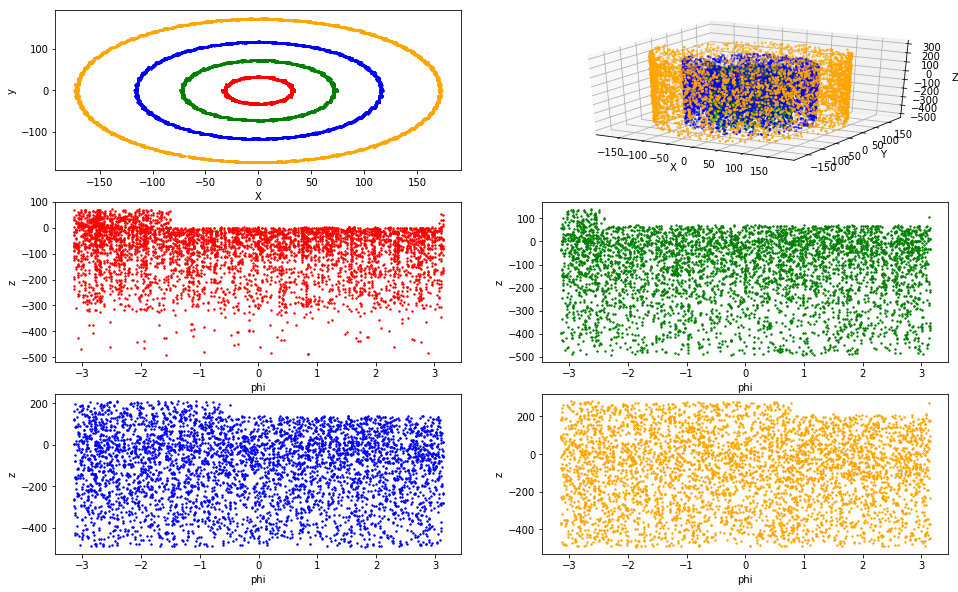

In [340]:
n_num=5000
fig=plt.figure(figsize=(16,10))
fig.add_subplot(3,2,1)
ax = fig.gca()
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.scatter(layer_layout2[:n_num,0], layer_layout2[:n_num,1],s=2,c='red')
ax.scatter(layer_layout4[:n_num,0], layer_layout4[:n_num,1],s=2,c='green')
ax.scatter(layer_layout6[:n_num,0], layer_layout6[:n_num,1],s=2,c='blue')
ax.scatter(layer_layout8[:n_num,0], layer_layout8[:n_num,1],s=2,c='orange')

fig.add_subplot(3,2,2,projection='3d')
ax = fig.gca(projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.scatter(layer_layout2[:n_num,0], layer_layout2[:n_num,1], layer_layout2[:n_num,2],s=2,c='red')
ax.scatter(layer_layout4[:n_num,0], layer_layout4[:n_num,1], layer_layout4[:n_num,2],s=2,c='green')
ax.scatter(layer_layout6[:n_num,0], layer_layout6[:n_num,1], layer_layout6[:n_num,2],s=2,c='blue')
ax.scatter(layer_layout8[:n_num,0], layer_layout8[:n_num,1], layer_layout8[:n_num,2],s=2,c='orange')

fig.add_subplot(3,2,3)
ax = fig.gca()
ax.set_xlabel("phi")
ax.set_ylabel("z")
ax.scatter(np.arctan2(layer_layout2[:n_num,1],layer_layout2[:n_num,0]), layer_layout2[:n_num,2],s=2,c='red')
fig.add_subplot(3,2,4)
ax = fig.gca()
ax.set_xlabel("phi")
ax.set_ylabel("z")
ax.scatter(np.arctan2(layer_layout4[:n_num,1],layer_layout4[:n_num,0]), layer_layout4[:n_num,2],s=2,c='green')
fig.add_subplot(3,2,5)
ax = fig.gca()
ax.set_xlabel("phi")
ax.set_ylabel("z")
ax.scatter(np.arctan2(layer_layout6[:n_num,1],layer_layout6[:n_num,0]), layer_layout6[:n_num,2],s=2,c='blue')
fig.add_subplot(3,2,6)
ax = fig.gca()
ax.set_xlabel("phi")
ax.set_ylabel("z")
ax.scatter(np.arctan2(layer_layout8[:n_num,1],layer_layout8[:n_num,0]), layer_layout8[:n_num,2],s=2,c='orange')
plt.show()

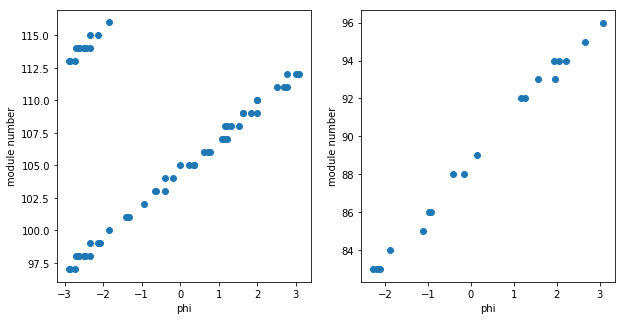

In [153]:
temp=np.array([[np.arctan2(layer_layout2[i,1],layer_layout2[i,0]), layer_layout2[i,2], layer_layout2[i,3]] for i in range(n_num)])
temp0=temp[abs(temp[:,1]) < 1][:,[0,2]]
temp2=temp[abs(temp[:,1]+100) < 1][:,[0,2]]
#temp0=temp0[:,[0,2]]
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("phi")
ax.set_ylabel("module number")
ax.scatter(temp0[:,0],temp0[:,1])
ax = fig.add_subplot(1,2,2)
ax.set_xlabel("phi")
ax.set_ylabel("module number")
ax.scatter(temp2[:,0],temp2[:,1])
plt.show()

In [152]:
temp[np.abs(temp[:,1]+100) < 1]

array([[  -2.1057514 , -100.        ,   83.        ],
       [  -2.17634099, -100.        ,   83.        ],
       [  -2.26945615, -100.        ,   83.        ],
       [  -1.88283845, -100.        ,   84.        ],
       [  -1.10714872, -100.        ,   85.        ],
       [  -0.96525166, -100.        ,   86.        ],
       [  -0.92092588, -100.        ,   86.        ],
       [  -0.15991312, -100.        ,   88.        ],
       [  -0.42419441, -100.        ,   88.        ],
       [   0.15499674, -100.        ,   89.        ],
       [   1.25875421, -100.        ,   92.        ],
       [   1.17371688, -100.        ,   92.        ],
       [   1.96313647, -100.        ,   93.        ],
       [   1.57079633, -100.        ,   93.        ],
       [   2.22066678, -100.        ,   94.        ],
       [   1.929567  , -100.        ,   94.        ],
       [   2.04814171, -100.        ,   94.        ],
       [   2.64978348, -100.        ,   95.        ],
       [   3.07716581, -100.

In [85]:
np.array(layer_layout2[:3,1])

array([-3.648710012435913, -1.9347399473190308, -18.4237003326416],
      dtype=object)